<a href="https://colab.research.google.com/github/Shamoo100/Augmentor/blob/master/text_classification_code_refactored.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This notebook demonstrates how to extract, transform, and load the TUABtxt dataset for use with Tensorflow.

First, let's install and import some useful libraries.

In [1]:
# Be sure you're using the stable versions of both tf and tf-text, for binary compatibility.
!pip install -q -U tensorflow==2.7
!pip install -q -U tensorflow-text==2.7

In [2]:
import collections
import pathlib
import re
import string
import numpy as np
import pandas as pd

import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras import utils
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

import tensorflow_datasets as tfds
import tensorflow_text as tf_text

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Download and Inspect the dataset

First we'll use a handy tool called `gdown` to download the dataset (just the text reports) from where your team have stored them on Google Drive.

In [3]:
! pip install gdown

In [4]:
!gdown --id 120d8bHo6NxEsUDprDqiuqj1OTfmhgJzR

Downloading...
From: https://drive.google.com/uc?id=120d8bHo6NxEsUDprDqiuqj1OTfmhgJzR
To: /content/TUAB_txt_relabelled.tar
100% 12.3M/12.3M [00:00<00:00, 45.5MB/s]


The dataset is compressed inside the archive file TUABtxt.tar, so let's extract it (like unzipping a zip file).

In [5]:
import tarfile
tar = tarfile.open("TUAB_txt_relabelled.tar")
tar.extractall()
tar.close()

Now we've extracted a folder called TUAB_txt_relabelled. Let's use pathlib library to explore this directory.

In [6]:
dataset_dir = pathlib.Path('TUAB_txt_relabelled/v2.0.0/edf') # First create a Path variable.
list(dataset_dir.iterdir())           # Then print a list of the folders contained in TUABtxt

[PosixPath('TUAB_txt_relabelled/v2.0.0/edf/eval'),
 PosixPath('TUAB_txt_relabelled/v2.0.0/edf/train')]

We see above that the dataset has already been split into 'train' and 'eval' subsets. This is common practice in widely used machine learning research datasets, to ensure that everyone uses the same test (eval) set when comparing performance.


However will load a sample of the dataset, Print an example file and inspect the data:

In [7]:
sample_file_dir = pathlib.Path('/content/TUAB_txt_relabelled/Exclude')
sample_file = sample_file_dir/'00009316_s001.txt'

with open(sample_file) as f:
  print(f.read())

LENGTH OF RECORDING:  22 minutes.
CLINICAL HISTORY:  The patient is a 49-year-old gentleman who had a seizure yesterday in the setting of severe tachycardia and desaturation to a pulse ox of 35.
MEDICATIONS:  Ativan given yesterday, citalopram.
INTRODUCTION:
DESCRIPTION OF THE RECORD:  The patient is asleep throughout the majority of the EEG.  During very brief wakefulness, there is a posterior dominant rhythm of 8.5 Hz with anterior to posterior frequency amplitude gradient.  Throughout the majority of the study, the patient is asleep with vertex waves, sleep spindles, and POSTS seen.  Also, REM sleep is observed by the end of the recording.  Hyperventilation and photic stimulation were not performed.  No epileptiform discharges were observed.
FINDINGS:  Primarily asleep study to REM sleep at the end of the recording.
IMPRESSION:  This is an abnormal primarily asleep and briefly awake EEG due to excessive drowsiness and REM sleep captured on a 22-minute study.  These findings indicate

### Load the full dataset

Next, we will load the data off disk and prepare it into a format suitable for training. The [text_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text_dataset_from_directory) utility makes this easy, and creates a `tf.data.Dataset` object with labels ('normal' and 'abnormal') automatically recognised from the folder structure. ([tf.data](https://www.tensorflow.org/guide/data) is a collection of tools for building input pipelines for machine learning).

In [8]:
train_and_val_ds = preprocessing.text_dataset_from_directory(dataset_dir/'train', batch_size=32)
raw_test_ds = preprocessing.text_dataset_from_directory(dataset_dir/'eval', batch_size=32)

Found 2716 files belonging to 2 classes.
Found 276 files belonging to 2 classes.


After loading the data, it’s good practice to run some checks on it: pick a few samples and manually check if they are consistent with your expectations. For example, print a few random samples to see if the sentiment label corresponds to the diagnosis of the report. Here is a review we picked at random from the TUAB dataset: “'CLINICAL HISTORY:  44 year old right handed female with significant cardiac disease, admitted with crushing substantial chest pain and facial twitching.  Radiculopathy.....” The expected diagnosis (abnormal) matches the sample’s label.

The above does not represent the true sample of the entire data, this is because the `batch_size` is set to 32 and has been converted to a tensor, we will modify the lines of code to extracts all the data and its labels to enable us do more in depth exploration.

In [9]:
# Changes to extract all  data starts here
#change batch_size to accomodate all data
train_and_val_data = preprocessing.text_dataset_from_directory(dataset_dir/'train', batch_size=3200)
raw_test_data = preprocessing.text_dataset_from_directory(dataset_dir/'eval', batch_size=3200)

Found 2716 files belonging to 2 classes.
Found 276 files belonging to 2 classes.


In [10]:
for text_batch, label_batch in train_and_val_data:   # Take a single batch from the dataset.
  for i in range(10):                                # Iterate through the first 10 examples in that batch.
    print("Report: ", text_batch.numpy()[i])
    print("Label:", label_batch.numpy()[i])

Report:  b'CLINICAL HISTORY:  A 25-year-old male with childhood brain tumor, status post radiation and resection.  The patient admitted on the 27th, one day after seizure with persistent, right-sided weakness.\nMEDICATIONS:\nINTRODUCTION:  Digital video EEG was performed in the lab using standard 10-20 system of electrode placement with one channel of EKG.  The patient was relatively alert, but had increasing right-sided weakness.\nDESCRIPTION OF THE RECORD:  The patient seems to be a bit drowsy.  In the drowsy state, there is a low voltage 8 Hz alpha rhythm on the right.  From the left hemisphere, continue with focal slowing was identified with arrhythmic delta, a breach rhythm with higher amplitude delta and sharply contoured slowing with variable maxima, T1, T3.  There was also focal delta picked up in the left centroparietal region.  The patient does maintain an awake state during the later portions of the record, but with somewhat disorganized pattern on the right and an alpha rhy

In [11]:
# insert features and labels into a dataframe
data = pd.DataFrame(text_batch.numpy(),columns = ['Text_records'])
data['labels'] = label_batch.numpy()


In [12]:
#inspect the first 5 in a dataframe
data.head()

,Text_records,labels
0,b'CLINICAL HISTORY: A 25-year-old male with c...,0
1,b'HISTORY: A 33-year-old right-handed woman w...,1
2,b'CLINICAL HISTORY: 46 year old right handed m...,0
3,"b""CLINICAL HISTORY: 34 year old left handed wo...",1
4,b'CLINICAL HISTORY: 20 year old right handed ...,1


Above has been converted to a .csv format for a better view, however there are more features(topics) to explore, this will require spliting Text_records into sub columns and doing some feature extraction.

In [13]:
### save the dataframe
data.to_csv('text_data_train.csv',index = False)

The data will be saved to csv for further exploratoin such as topic modelling, bag of words and sentiment analysis.

When running a machine learning experiment, it is a best practice to divide your dataset into three splits: [train](https://developers.google.com/machine-learning/glossary#training_set), [validation](https://developers.google.com/machine-learning/glossary#validation_set), and [test](https://developers.google.com/machine-learning/glossary#test-set). There are no strict rules, but usually it's best to put most of your data in the training (so that there's plenty to learn from. Let's split the training-and-validation data into 80% training and 20% validation.

In [14]:
# Set the size of each subset of data:
n = len(list(train_and_val_ds)) # Number of batches in original 'train' dataset
n_train = int(0.8*n)   # Use about 80% as training data ...
n_val = int(0.2*n)     # and 20% as validation data.

Now we're ready to actually make the split.

In [15]:
# Split the data into training, validation, and test sets:
raw_train_ds = train_and_val_ds.take(n_train)
raw_val_ds = train_and_val_ds.skip(n_train)

Let's print out a few examples, to get more of a feel for the data.

In [16]:
for text_batch, label_batch in raw_train_ds.take(1):   # Take a single batch from the dataset.
  for i in range(10):                                  # Iterate through the first 10 examples in that batch.
    print("Report: ", text_batch.numpy()[i])
    print("Label:", label_batch.numpy()[i])

Report:  b'CLINICAL HISTORY:  47 year old man with a history of hypertension, dementia, alcohol abuse, diabetes, chronic renal insufficiency who presents after being found down at the bottom of the stairs with bowel and bladder incontinence. The patient also has a history of prior stroke with right sided weakness.\nMEDICATIONS:  Protonix, Aspirin, heparin, hydralazine.\nREASON FOR STUDY:  Confusion.\nINTRODUCTION:  Digital video EEG was performed at bedside using standard 10-20 system of electrode placement with 1 channel of EKG.  Recording was mainly in wakefulness with some drowsiness. Activating procedure was only photic stimulation.\nTECHNICAL  DIFFICULTIES:  Continuous muscle artifact throughout the recording.\nDESCRIPTION OF THE RECORD:  The record opens to a low amplitude posterior dominant rhythm that as best as can be seen at 9 hertz with a low amplitude of 20-40 microvolts. In addition, there is a increased amount of diffuse beta seen throughout the recording. Drowsiness is s

The labels are `0` or `1`. To see which of these correspond to which string label, you can check the `class_names` property on the dataset, as below.


In [17]:
for i, label in enumerate(train_and_val_ds.class_names):
  print("Label", i, "corresponds to", label)

Label 0 corresponds to abnormal
Label 1 corresponds to normal


##Explore Dataset
We will look at understanding the dataset by doing a brief Exploratory data analysis using text exploration

We will look at collecting key metrics as follows:

Number of samples: Total number of examples you have in the data.

Number of classes: Total number of topics or categories in the data.

Number of samples per class: Number of samples per class (topic/category). In a balanced dataset, all classes will have a similar number of samples; in an imbalanced dataset, the number of samples in each class will vary widely.

Number of words per sample: Median number of words in one sample.

Frequency distribution of words: Distribution showing the frequency (number of occurrences) of each word in the dataset.

Distribution of sample length: Distribution showing the number of words per sample in the dataset.

In [18]:
"""Module to explore data.
Contains functions to help study, visualize and understand datasets.
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer


def get_num_classes(labels):
    """Gets the total number of classes.
    # Arguments
        labels: list, label values.
            There should be at lease one sample for values in the
            range (0, num_classes -1)
    # Returns
        int, total number of classes.
    # Raises
        ValueError: if any label value in the range(0, num_classes - 1)
            is missing or if number of classes is <= 1.
    """
    num_classes = max(labels) + 1
    missing_classes = [i for i in range(num_classes) if i not in labels]
    if len(missing_classes):
        raise ValueError('Missing samples with label value(s) '
                         '{missing_classes}. Please make sure you have '
                         'at least one sample for every label value '
                         'in the range(0, {max_class})'.format(
                            missing_classes=missing_classes,
                            max_class=num_classes - 1))

    if num_classes <= 1:
        raise ValueError('Invalid number of labels: {num_classes}.'
                         'Please make sure there are at least two classes '
                         'of samples'.format(num_classes=num_classes))
    return num_classes


def get_num_words_per_sample(sample_texts):
    """Gets the median number of words per sample given corpus.
    # Arguments
        sample_texts: list, sample texts.
    # Returns
        int, median number of words per sample.
    """
    num_words = [len(s.split()) for s in sample_texts]
    return np.median(num_words)


def plot_frequency_distribution_of_ngrams(sample_texts,
                                          ngram_range=(1, 5),
                                          num_ngrams=50):
    """Plots the frequency distribution of n-grams.
    # Arguments
        samples_texts: list, sample texts.
        ngram_range: tuple (min, mplt), The range of n-gram values to consider.
            Min and mplt are the lower and upper bound values for the range.
        num_ngrams: int, number of n-grams to plot.
            Top `num_ngrams` frequent n-grams will be plotted.
    """
    # Create args required for vectorizing.
    kwargs = {
            'ngram_range': (1, 1),
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': 'word',  # Split text into word tokens.
    }
    vectorizer = CountVectorizer(**kwargs)

    # This creates a vocabulary (dict, where keys are n-grams and values are
    # idxices). This also converts every text to an array the length of
    # vocabulary, where every element idxicates the count of the n-gram
    # corresponding at that idxex in vocabulary.
    vectorized_texts = vectorizer.fit_transform(sample_texts)

    # This is the list of all n-grams in the index order from the vocabulary.
    all_ngrams = list(vectorizer.get_feature_names())
    num_ngrams = min(num_ngrams, len(all_ngrams))
    # ngrams = all_ngrams[:num_ngrams]

    # Add up the counts per n-gram ie. column-wise
    all_counts = vectorized_texts.sum(axis=0).tolist()[0]

    # Sort n-grams and counts by frequency and get top `num_ngrams` ngrams.
    all_counts, all_ngrams = zip(*[(c, n) for c, n in sorted(
        zip(all_counts, all_ngrams), reverse=True)])
    ngrams = list(all_ngrams)[:num_ngrams]
    counts = list(all_counts)[:num_ngrams]

    idx = np.arange(num_ngrams)

    plt.bar(idx, counts, width=0.8, color='b')
    plt.xlabel('N-grams')
    plt.ylabel('Frequencies')
    plt.title('Frequency distribution of n-grams')
    plt.xticks(idx, ngrams, rotation=45)
    plt.show()


def plot_sample_length_distribution(sample_texts):
    """Plots the sample length distribution.
    # Arguments
        samples_texts: list, sample texts.
    """
    plt.hist([len(s) for s in sample_texts], 50)
    plt.xlabel('Length of a sample')
    plt.ylabel('Number of samples')
    plt.title('Sample length distribution')
    plt.show()


def plot_class_distribution(labels):
    """Plots the class distribution.
    # Arguments
        labels: list, label values.
            There should be at lease one sample for values in the
            range (0, num_classes -1)
    """
    num_classes = get_num_classes(labels)
    count_map = Counter(labels)
    counts = [count_map[i] for i in range(num_classes)]
    idx = np.arange(num_classes)
    plt.bar(idx, counts, width=0.8, color='b')
    plt.xlabel('Class')
    plt.ylabel('Number of samples')
    plt.title('Class distribution')
    plt.xticks(idx, idx)
    plt.show()

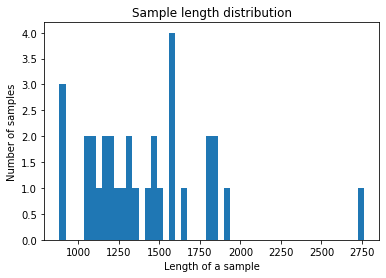

In [19]:
plot_sample_length_distribution(text_batch.numpy())

In [20]:
get_num_words_per_sample(text_batch.numpy())

203.0

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


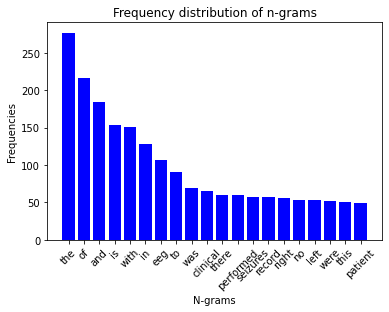

In [21]:
plot_frequency_distribution_of_ngrams(text_batch.numpy(),num_ngrams=20)

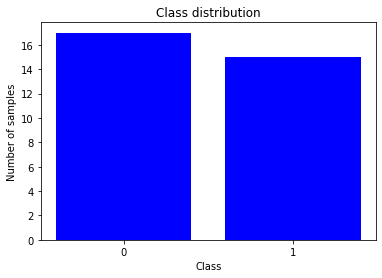

In [22]:
#labels: 0-normal , 1-abormal
plot_class_distribution(label_batch.numpy())

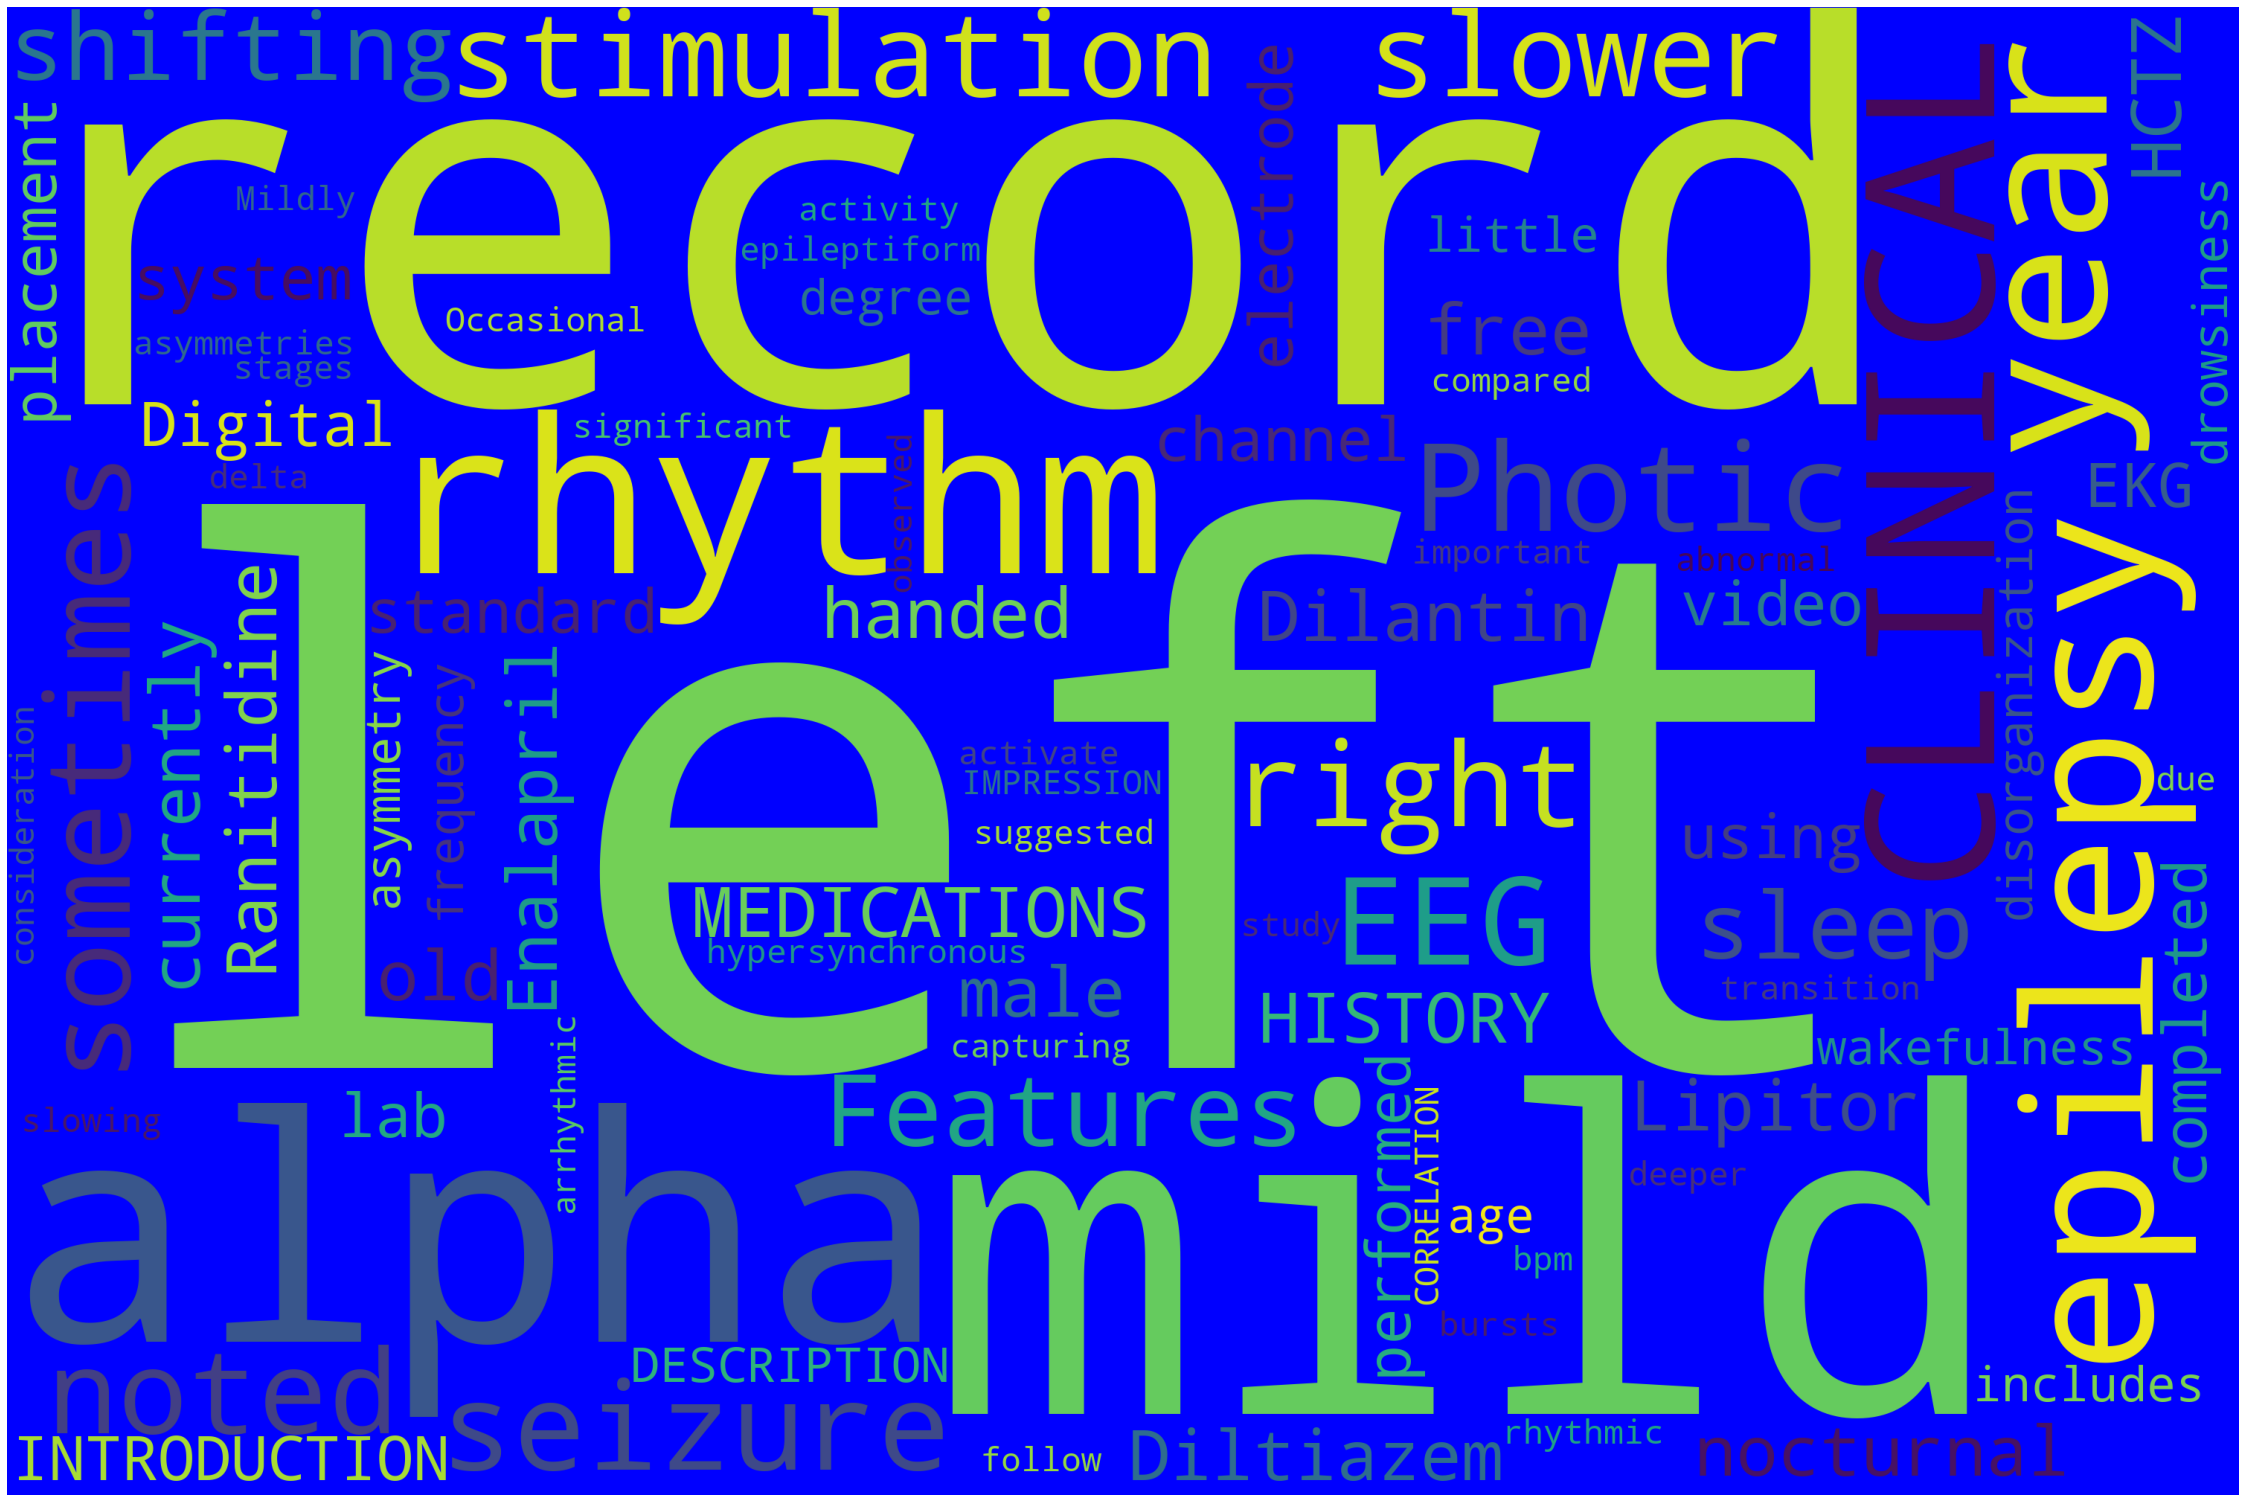

In [23]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS 
# stopwords is a collection of words that dont convey meaning. mostly pronouns such as he she etc.

#generate word cloud
for text_batch, label_batch in train_and_val_data:   # Take a single batch from the dataset.
  for i in range(50):
    data_all = text_batch.numpy()[i]  # Iterate through the first 10 examples in that batch.
                                     
    
 
text = data_all.decode("utf-8")  # the input of the wordcloud generator
#generate the wordcloud object, set the height and width, set the random_state parameter to ensure
#reproducibility of results and set the stopwords parameter so that the irrelevant words such as pronouns are discarded.
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='blue', collocations=False, stopwords = STOPWORDS).generate(text)
# text is the input to the generate() method
#draw the figure
#Set figure size
plt.figure(figsize=(40, 30))
# Display image
plt.imshow(wordcloud) 
# No axis 
plt.axis("off")
plt.show()

### Prepare the dataset for training

Next, you will standardize, tokenize, and vectorize the data using the `preprocessing.TextVectorization` layer.
* Standardization refers to preprocessing the text, typically to remove punctuation or HTML elements to simplify the dataset.

* Tokenization refers to splitting strings into tokens (for example, splitting a sentence into individual words by splitting on whitespace).

* Vectorization refers to converting tokens into numbers so they can be fed into a neural network.

All of these tasks can be accomplished with this layer. You can learn more about each of these in the [API doc](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/TextVectorization).

* The default standardization converts text to lowercase and removes punctuation.

* The default tokenizer splits on whitespace.

* The default vectorization mode is `int`. This outputs integer indices (one per token). This mode can be used to build models that take word order into account. You can also use other modes, like `binary`, to build bag-of-word models.


Here we will use the `binary` mode to build a bag-of-words model (essentially one-hot encoding of whether each word in the vocabulary appears in the report). Then we will use the `int` mode (integer encoding of each word in the report, with order preserved) with a 1D ConvNet.

In [24]:
VOCAB_SIZE = 10000

binary_vectorize_layer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='binary')

For `int` mode, in addition to maximum vocabulary size, you need to set an explicit maximum sequence length, which will cause the layer to pad or truncate sequences to exactly sequence_length values.

In [25]:
MAX_SEQUENCE_LENGTH = 250

int_vectorize_layer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=MAX_SEQUENCE_LENGTH)

Next, you will call `adapt` to make the VectorizationLayer adjust itself according to the vocabulary in the dataset.

Note: it's important to only use your training data when calling adapt (using the test set would leak information).

In [26]:
# To avoid some errors caused by non-standard characters, we create a function
# that does some additional 'cleaning' of the text.
def clean_text(text, labels):
  cleaned_version_of_text = tf.strings.unicode_transcode(text, "US ASCII", "UTF-8") 
  return cleaned_version_of_text
  
# Now apply our clean_text function to the full dataset.
train_text = raw_train_ds.map(clean_text) 

# Finally, let the vectorize layers adjust themselves to fit the vocabulary of the dataset.
binary_vectorize_layer.adapt(train_text)
int_vectorize_layer.adapt(train_text)

See the result of using these layers to preprocess data:

In [27]:
def binary_vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return binary_vectorize_layer(text), label

In [28]:
def int_vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return int_vectorize_layer(text), label

In [29]:
# Retrieve a batch (of 32 reports and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_report, first_label = text_batch[0], label_batch[0]
print("Report", first_report)
print("Label", first_label)

Report tf.Tensor(b'CLINICAL HISTORY: 35 year old right handed female with blackout spells for the last 2 years occurring 1-3 times a year and migraine headaches 2-4 times per week. This is an outpatient EEG.\n\nMEDICATIONS: Unknown.\n\nINTRODUCTION: Digital video EEG was performed in lab using standard 10-20 system of electrode placement with 1 channel EKG. Hyperventilation and photic simulation were performed.\n\nDESCRIPTION OF THE RECORD: In wakefulness there is a low voltage g Hertz posterior dominant rhythm. The patient transitions rapidly into stage 1 and stage 2 sleep with rhythmic central theta followed by vertex waves, K-complexes, spindles and posts. Abrupt arousals are noted in and out of stage 2 sleep with at that point a 10 point 7 Hertz alpha rhythm. Hyperventilation does not activate the record. Photic stimulation elicits a vigorous driving response with harmonic and supra harmonic driving.\n\nHR: 72bpm\n\nIMPRESSION: Normal EEG.\n\nCLINICAL CORRELATION: No focal nor epil

In [30]:
print("'binary' vectorized report:", 
      binary_vectorize_text(first_report, first_label)[0])

'binary' vectorized report: tf.Tensor([[0. 1. 1. ... 0. 0. 0.]], shape=(1, 6530), dtype=float32)


In [31]:
print("'int' vectorized report:",
      int_vectorize_text(first_report, first_label)[0])

'int' vectorized report: tf.Tensor(
[[  12   18  703   72   74   19  111  226    7 1067  370   54    2  200
    99  292  789  724  209    6   72    4  647  386  247  209  270  650
    16    5   25  820    9   34  645   48   60   59    9   11   13    8
    86   49   45   46   44    3   28   51    7   55   71   38   33    4
    21  378   26   13   42    3    2   14    8   35   15    5    6  116
   129 3744  324   65   93   32    2   17  349 1081  329   69   55    4
    69   99   24    7  119  126   76  231   95  143   58  607  199    4
   230 1635  678   30   77    8    4  171    3   69   99   24    7   29
    84  924    6  172  924  402  324   70   32   33  109   53  222    2
    14   21   20  164    6  513  107  168    7  707    4 1914  707  107
   100 1523   43   37    9   12   47   22   66  360   50   83   30  161
     2  349    8    4  171    3   24   30   53 2385 1553    3  448 3404
     3 1015    4  280   63   56    8 4511  206    5    6 1441 4534   24
   996   67  136  710 5769  

As you can see above, `binary` mode returns an array denoting which tokens exist at least once in the input, while `int` mode replaces each token by an integer, thus preserving their order. You can lookup the token (string) that each integer corresponds to by calling `.get_vocabulary()` on the layer.

In [32]:
print("12 ---> ", int_vectorize_layer.get_vocabulary()[12])
print("18 ---> ", int_vectorize_layer.get_vocabulary()[18])
print("Vocabulary size: {}".format(len(int_vectorize_layer.get_vocabulary())))

12 --->  clinical
18 --->  history
Vocabulary size: 6532


You are nearly ready to train your model. As a final preprocessing step, you will apply the `TextVectorization` layers you created earlier to the train, validation, and test dataset.

In [33]:
binary_train_ds = raw_train_ds.map(binary_vectorize_text)
binary_val_ds = raw_val_ds.map(binary_vectorize_text)
binary_test_ds = raw_test_ds.map(binary_vectorize_text)

int_train_ds = raw_train_ds.map(int_vectorize_text)
int_val_ds = raw_val_ds.map(int_vectorize_text)
int_test_ds = raw_test_ds.map(int_vectorize_text)

### Configure the dataset for performance

These are two important methods you should use when loading data to make sure that I/O does not become blocking.

- `Dataset.cache` keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

You can learn more about both methods, as well as how to cache data to disk in the *Prefetching* section of the [Better performance with the tf.data API](../../guide/data_performance.ipynb) guide.

In [34]:
AUTOTUNE = tf.data.AUTOTUNE

def configure_dataset(dataset):
  return dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [35]:
binary_train_ds = configure_dataset(binary_train_ds)
binary_val_ds = configure_dataset(binary_val_ds)
binary_test_ds = configure_dataset(binary_test_ds)

int_train_ds = configure_dataset(int_train_ds)
int_val_ds = configure_dataset(int_val_ds)
int_test_ds = configure_dataset(int_test_ds)

### Train the model

It's time to create your neural network.

For the `'binary'` vectorized data, define a simple bag-of-words linear model, then configure and train it:

### binary_model_classifier

In [36]:
def binary_model_classifier(train_ds,validation_ds,n_neurons = 4,epochs = 10):
    binary_model = tf.keras.Sequential([layers.Dense(n_neurons)])

    binary_model.compile(
        loss=losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer='adam',
        metrics=['accuracy'])
    
    history = binary_model.fit(
        train_ds, validation_data=binary_val_ds, epochs=epochs)
    print("\n Linear model on binary vectorized data:")
    print(binary_model.summary())
    return binary_model,history

In [37]:
binary_model,history = binary_model_classifier(binary_train_ds, binary_val_ds,4)

Epoch 1/10
68/68 [==============================] - 2s 28ms/step - loss: 0.5023 - accuracy: 0.8741 - val_loss: 0.2444 - val_accuracy: 0.9593
Epoch 2/10
68/68 [==============================] - 0s 3ms/step - loss: 0.1799 - accuracy: 0.9743 - val_loss: 0.1546 - val_accuracy: 0.9741
Epoch 3/10
68/68 [==============================] - 0s 4ms/step - loss: 0.1179 - accuracy: 0.9862 - val_loss: 0.1174 - val_accuracy: 0.9833
Epoch 4/10
68/68 [==============================] - 0s 3ms/step - loss: 0.0869 - accuracy: 0.9890 - val_loss: 0.0964 - val_accuracy: 0.9870
Epoch 5/10
68/68 [==============================] - 0s 3ms/step - loss: 0.0678 - accuracy: 0.9917 - val_loss: 0.0828 - val_accuracy: 0.9870
Epoch 6/10
68/68 [==============================] - 0s 4ms/step - loss: 0.0547 - accuracy: 0.9949 - val_loss: 0.0734 - val_accuracy: 0.9870
Epoch 7/10
68/68 [==============================] - 0s 3ms/step - loss: 0.0452 - accuracy: 0.9968 - val_loss: 0.0665 - val_accuracy: 0.9870
Epoch 8/10
68/68 [=

Next, you will use the `'int'` vectorized layer to build a 1D ConvNet:

### 1D ConvNet

In [38]:
def conv_net_model(int_train_ds,int_val_ds,vocab_size, num_labels):
    vocab_size=VOCAB_SIZE + 1
    model = tf.keras.Sequential([
    layers.Embedding(vocab_size, 64, mask_zero=True),
    layers.Conv1D(64, 5, padding="valid", activation="relu", strides=2),
    layers.GlobalMaxPooling1D(),
    layers.Dense(num_labels)])
    model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy'])
    history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=5)
    print("\n ConvNet model on int vectorized data:")
    print(model.summary())
    return model,history

In [39]:
conv_model,conv_history = conv_net_model(int_train_ds,int_val_ds,vocab_size = VOCAB_SIZE, num_labels = 4)

Epoch 1/5
68/68 [==============================] - 3s 44ms/step - loss: 0.7568 - accuracy: 0.7335 - val_loss: 0.3035 - val_accuracy: 0.9796
Epoch 2/5
68/68 [==============================] - 2s 26ms/step - loss: 0.1087 - accuracy: 0.9936 - val_loss: 0.0497 - val_accuracy: 0.9926
Epoch 3/5
68/68 [==============================] - 2s 26ms/step - loss: 0.0220 - accuracy: 0.9977 - val_loss: 0.0325 - val_accuracy: 0.9944
Epoch 4/5
68/68 [==============================] - 2s 26ms/step - loss: 0.0110 - accuracy: 0.9995 - val_loss: 0.0283 - val_accuracy: 0.9926
Epoch 5/5
68/68 [==============================] - 2s 26ms/step - loss: 0.0066 - accuracy: 0.9995 - val_loss: 0.0268 - val_accuracy: 0.9926

 ConvNet model on int vectorized data:
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          640064    
                                        

Compare the two models:

Evaluate both models on the test data:

In [40]:
binary_loss, binary_accuracy = binary_model.evaluate(binary_test_ds)
int_loss, int_accuracy = conv_model.evaluate(int_test_ds)

print("Binary model accuracy: {:2.2%}".format(binary_accuracy))
print("Int model accuracy: {:2.2%}".format(int_accuracy))

9/9 [==============================] - 0s 7ms/step - loss: 0.0118 - accuracy: 0.9964
Binary model accuracy: 98.19%
Int model accuracy: 99.64%


Note: This example dataset represents a rather simple classification problem. More complex datasets and problems bring out subtle but significant differences in preprocessing strategies and model architectures. Be sure to try out different hyperparameters and epochs to compare various approaches.

### Export the model

In the code above, you applied `tf.keras.layers.TextVectorization` to the dataset before feeding text to the model. If you want to make your model capable of processing raw strings (for example, to simplify deploying it), you can include the `TextVectorization` layer inside your model.

To do so, you can create a new model using the weights you have just trained:

In [41]:
export_model = tf.keras.Sequential(
    [binary_vectorize_layer, binary_model,
     layers.Activation('sigmoid')])

export_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=['accuracy'])

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print("Accuracy: {:2.2%}".format(binary_accuracy))

9/9 [==============================] - 0s 4ms/step - loss: 0.0639 - accuracy: 0.9819
Accuracy: 98.19%


Now, your model can take raw strings as input and predict a score for each label using `Model.predict`. Define a function to find the label with the maximum score:

In [42]:
def get_string_labels(predicted_scores_batch):
  predicted_int_labels = tf.argmax(predicted_scores_batch, axis=1)
  predicted_labels = tf.gather(raw_train_ds.class_names, predicted_int_labels)
  return predicted_labels

Including the text preprocessing logic inside your model enables you to export a model for production that simplifies deployment, and reduces the potential for [train/test skew](https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew).

There is a performance difference to keep in mind when choosing where to apply `tf.keras.layers.TextVectorization`. Using it outside of your model enables you to do asynchronous CPU processing and buffering of your data when training on GPU. So, if you're training your model on the GPU, you probably want to go with this option to get the best performance while developing your model, then switch to including the `TextVectorization` layer inside your model when you're ready to prepare for deployment.

Visit the [Save and load models](../keras/save_and_load.ipynb) tutorial to learn more about saving models.

# Rule-Based (non-ML) Approach

Looking through the reports, it seems as though it's usually stated quite clearly when the EEG is abnormal. Rather than attempting any machine learning, why don't we just look for that key word (or related words/phrases) in the text? This approach is implemented below.

In [43]:
def rule_based_classifier(train_and_val_ds):
    n= 0
    n_correct = 0
    n_failed_decode = 0
    y_label = [] #store actual labels here
    prediction = [] #store predictions here

    # Iterate over all batches, taking the text and labels batch-by-batch.
    # N.B. take(-1) has the effect of pulling out all the batches, instead of a specific number, as explained in the docs here: https://www.tensorflow.org/api_docs/python/tf/data/Dataset#take
    for text_batch, label_batch in train_and_val_ds.take(-1):
    # for text_batch, label_batch in raw_test_ds.take(-1):

      # Iterate over the report examples in the batch:
          for ind,text in enumerate(text_batch):

            # Get rid of any pesky non-standard characters using the function we created previously.
            cleaned_text = clean_text(text,0)
            # Then convert it from a tensorflow Tensor to a python string so that we can 
            # use some standard python text analysis on it.
            cleaned_and_decoded_text = cleaned_text.numpy().decode("UTF-8")

            check_impression = re.search('impression', cleaned_and_decoded_text.lower(), flags=re.IGNORECASE)
            check_clinical_correlation = re.search('clinical correlation:', cleaned_and_decoded_text.lower(), flags=re.IGNORECASE)
            first_char_impression, last_char_impression = check_impression.span()

            if check_clinical_correlation != None:
              first_char_clinical_correlation, last_char_clinical_correlation = check_clinical_correlation.span()
            else: first_char_clinical_correlation = last_char_impression + 50

            search = cleaned_and_decoded_text.lower()[last_char_impression:first_char_clinical_correlation]

            check_abnormal = re.search('abnormal', search.lower(), flags=re.IGNORECASE)

            # Check if the word 'abnormal' is in the report, and label it accordingly.
            if check_abnormal:
              predicted_label = 0
              prediction.append(predicted_label)
            else:
              predicted_label = 1
              prediction.append(predicted_label)


            # If we predicted correctly, add one to our count of correct predictions.
            y_label.append(label_batch[ind])
            if predicted_label==label_batch[ind]:
              n_correct = n_correct+1
            else:
              # Uncomment the lines below if you want to inspect the cases where we were wrong.
              #print("--- Wrong example ---")
              #print(text.numpy().decode("UTF-8"))
              #print()
              #print("---------------------")
              #print(f"The above example was classified with label {predicted_label} but it's actual label is {label_batch[ind].numpy()}.")
              #print("---------------------")
              pass

            # Add one to our count of the total number of examples examined.
            n = n+1
    # return predictions, labels and the accuracy
    return prediction,y_label,(100*n_correct/n)

In [44]:
pred,labels,acc= rule_based_classifier(train_and_val_ds)

In [45]:
#accuracy
accuracy_score(pred,labels)

0.9849042709867453

In [46]:
#classification report
print(classification_report(pred,labels))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99      1386
           1       0.97      1.00      0.98      1330

    accuracy                           0.98      2716
   macro avg       0.98      0.99      0.98      2716
weighted avg       0.99      0.98      0.98      2716



In [47]:
#print confusion metric
print(confusion_matrix(pred,labels))

[[1348   38]
 [   3 1327]]


The rule-based approach has an accuracy of 98.49%.
With the classification report showing that we have 

1348 True Positive

38   False Postive

1327 True Negative

3 False Negative



We will further compare all three classifiers to see which performs better using a bar-chat

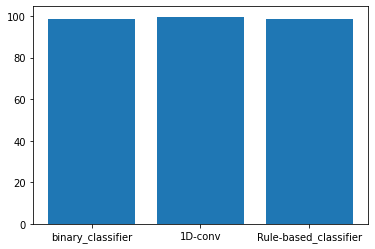

In [48]:
from IPython.core.pylabtools import figsize
Accuracy = {u'binary_classifier':98.55 , u'1D-conv':99.64, u'Rule-based_classifier':98.49}
# D = {u'Label1':26, u'Label2': 17, u'Label3':30}
plt.bar(*zip(*Accuracy.items()), width=0.8,)
plt.Figure(figsize = (5,10))
plt.show()

# Conclusion

To determine which approach was better in classifying EGG reports, three models were trained and evaluated. The best model was the 1d conv-net model, followed by the binary classifier, and the least performing model was the rule-based classifier. Furthermore, it is recommended that more data samples be collected and that pre-trained word embeddings be used as deep representation features to help improve the model's performance.